### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import importlib
import re

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

# Dictionaries: species_name to ba and vice versa
species_id_to_name = descriptions.species_id_to_name()
species_name_to_id = descriptions.species_name_to_id()

### Definitions

In [2]:
# Directory: Processed tnr%.hdf5s
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

# Directory: Plots
dir_plots = r"C:\Data\lwf\analysis\220825_veg-index\plots"

### Load crowns' features of all hdf5s
* As pandas.DataFrame

In [3]:
importlib.reload(io)

df, params_df = io.allhdf5s_crowns_features_to_dataframe(dir_hdf5, crowns_type='crowns_human')

# Replace inf values with nans
df = df.where(df != np.inf, np.nan)

### Assign families to crowns

In [4]:
importlib.reload(descriptions)

# Define families by patterns
family_patterns = [
    ' kiefer',
    ' fichte',
    'buche',
    'eiche',
]

families = descriptions.species_groupby_families(family_patterns)
family_ids = descriptions.species_id_to_family_id(df.ba.values, families)

df = df.assign(
    family = family_ids,
    )

### Infos

#### Search: Pattern in column names

In [5]:
pattern = 'min'

cols = list(df.columns)
for col in cols:
    if bool(re.search(pattern, col, re.IGNORECASE)):
        print(col)

axis_minor_length
min_chm
min_light
min_sat
min_hue
min_ndvi
min_ndvire
min_ndre
min_grvi
min_blue
min_green
min_red
min_re
min_nir
min_gob
min_rob
min_reob
min_nob
x_min_bbox
y_min_bbox
min_bright_chm
min_bright_light
min_bright_sat
min_bright_hue
min_bright_ndvi
min_bright_ndvire
min_bright_ndre
min_bright_grvi
min_bright_blue
min_bright_green
min_bright_red
min_bright_re
min_bright_nir
min_bright_gob
min_bright_rob
min_bright_reob
min_bright_nob
x_min_bbox_bright
y_min_bbox_bright


#### Info: Dataset

In [6]:
importlib.reload(descriptions)

descriptions.print_summary(
    df.tnr.values,
    df.ba.values,
    df.family.values,
    families,
)

Total number of crowns        : 3895
Mean number of crowns per tnr : 30.9
__________________________________________________

species_id| species_name                  | count
--------------------------------------------------
       134| Gemeine Kiefer                : 1544
       118| Gemeine Fichte                : 945
        20| Rotbuche                      : 448
       100| Weißtanne                     : 207
        48| Traubeneiche                  : 203
       116| Europäische Lärche            : 117
        51| Stieleiche                    : 93
        10| Gemeine Birke                 : 44
        22| Gemeine Esche                 : 43
         7| Schwarzerle                   : 38
        13| Hainbuche                     : 34
       136| Douglasie                     : 33
         5| Bergahorn                     : 23
       129| Schwarzkiefer                 : 16
        36| Kirsche                       : 15
         1| Feldahorn                     : 14
        68| Wi

### Plotting

#### Query & groupby: family, sst

In [7]:
############## Define queries
query_all = 'kkl in [1, 2, 3]'
query_all += ' and equivalent_diameter_area > 1'
query_all += ' and min_bright_ndre > 0'
query_all += ' and eccentricity > 0'
query_all += ' and eccentricity < 1'


############### Column
cols = [
    'family', 'sst',
    'median_bright_ndvi',
    'median_bright_ndvire',
    'median_bright_grvi',
    'median_bright_ndre',
]

############### Groupby
df_grouped = df.query(query_all).loc[:, cols].groupby(['family', 'sst']).describe()

#### Plotting: Vegetation indices

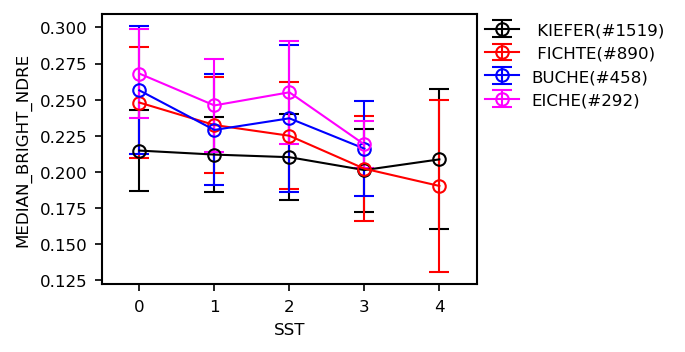

In [13]:
col = 'median_bright_ndre'
statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']

save_name = col + '.svg'


################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.7)
ax = f.add_subplot(111)

for i, (family_id, family) in enumerate(families.items()):

    # y-data: Define
    y = df_grouped.loc[(family_id, slice(None)), (col, statistics)].values
    yerr = df_grouped.loc[(family_id, slice(None)), (col, statistics_err)].values

    # y-data: Remove NaNs in case of single crown per family
    y = y[np.isfinite(yerr)]
    yerr = yerr[np.isfinite(yerr)]

    # x-data & counts
    x = range(len(y))
    counts = df_grouped.loc[(family_id, slice(None)), (col, 'count')].values
    counts = np.sum(counts)

    ax.errorbar(
        x,
        y,
        yerr,
        label=family['family_name'].upper() + f"(#{counts:.0f})",
        marker='o',
        c=colors[i],
        mec=colors[i],
        mfc='none',
        ms=6,
        capsize=5,
    )

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(range(5))
    ax.set_xlabel('SST')

    ax.set_ylabel(col.upper())

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)